## Import Statements

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint
from graphviz import Digraph

## Train-Test-Split

In [22]:
def train_test_split(df,test_size):
    if isinstance(test_size,float):
        test_size = round(test_size*len(df))
    indices = df.index.tolist()
    test_indices = random.sample(population=indices,k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    
    return train_df,test_df

## Helper Functions

## Data pure?

In [23]:
def check_purity(data):
    values = data[:,-1]
    unique_values = np.unique(values)
    if len(unique_values) == 1:
        return True
    else:
        return False

## Classify

In [24]:
def classify(data):
    """Returns the most dominant classifier in the dataset."""
    label_column = data[:,-1]
    unique_classes ,counts_unique_classes = np.unique(label_column,return_counts=True)
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    return classification

# print(classify.__doc__) #get documentation in the string.

## Potential splits?


In [25]:
def get_potential_splits(data):
    potential_splits = {}
    _,n_columns = data.shape

    for column_index in range(n_columns-1):
        values = data[:,column_index]
        unique_values = np.unique(values)
        
        type_of_feature = FEATURE_TYPES[column_index]
        
        potential_splits[column_index] = unique_values
                
    return potential_splits

## Split data

In [26]:
def split_data(data,split_column,split_value):
    split_column_values = data[:,split_column]
    
    type_of_feature = FEATURE_TYPES[split_column]
    
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values > split_value]
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below , data_above

## Lowest Overall Entropy?

In [27]:
def calculate_entropy(data):
    label_column = data[:,-1]
    _,counts = np.unique(label_column,return_counts=True)

    probabilities = counts / counts.sum()

    entropy = sum(probabilities * -np.log2(probabilities))
    
    return entropy

In [28]:
def calculate_overall_entropy(data_below,data_above):
    n_data_points = len(data_below) + len(data_above)

    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points

    overall_entropy = (p_data_below * calculate_entropy(data_below) + p_data_above * calculate_entropy(data_above))

    return overall_entropy

## Best Split

In [29]:
def determine_best_split(data,potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below , data_above = split_data(data,split_column = column_index,split_value = value)
            current_overall_entropy = calculate_overall_entropy(data_below , data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    return best_split_column , best_split_value

### Determine Type of Feature

In [30]:
def determine_type_of_feature(df):
    feature_types = []
    n_unique_values_threshold = 15
    
    for column in df.columns:
        unique_values = df[column].unique()
        example_values = unique_values[0]
        
        if isinstance(example_values,str) or (len(unique_values) <= n_unique_values_threshold):
            feature_types.append("categorical")
        else:
            feature_types.append("continuous")
    
    return feature_types


## Decision Tree Algorithm

## Representation of Decision Tree

## Algorithm

In [31]:
def decision_tree_algorithm(df,counter=0,min_samples = 2 , max_depth = 5):
    
    # data preparations.
    if counter == 0:
        global COLUMN_HEADERS,FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df
    
    # base case
    
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth): 
        classification = classify(data)
        return classification

    # recursive part
    else:
        counter += 1
        
        # helper functions
        potential_splits = get_potential_splits(data)
        
        split_column,split_value = determine_best_split(data,potential_splits)
        
        data_below,data_above = split_data(data,split_column,split_value)
        
        if len(data_below) == 0 or len(data_above) == 0:
            """If the data is empty just classify the dominant one as result."""
            classification = classify(data)
            return classification
        
        # creating sub tree
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = f"{feature_name} <= {split_value}"
        else:
            question = f"{feature_name} = {split_value}"
            
        sub_tree = {question:[]}
        
        # find answers(recursion)
        
        yes_answer  = decision_tree_algorithm(data_below , counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above , counter, min_samples, max_depth)
        # checking both answer are same or not
        
        if yes_answer == no_answer :
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree
        
    

## Classification

In [32]:
def classify_example(example,tree):
    question = list(tree.keys())[0]

    feature_name, comparison_operator, value = question.split()
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]


    if not isinstance(answer,dict):
        return answer
    # recursive part
    else:
        reduced_tree = answer
        return classify_example(example,reduced_tree)

## Accuracy Function

In [33]:
def calculate_accuracy(df,tree):
    
    df["classification"] = df.apply(classify_example,axis=1,args=(tree,))
    df["classification_correct"] = df.classification == df.label
    
    accuracy = df.classification_correct.mean()
    
    return accuracy

### Building Tree Diagram

In [34]:
def build_tree(tree):
    
    global tree_diagram
    global unique_suffix
    
    ## base case.
    if type(tree) != dict:
        
        ## if type is integer then return the the value.
        value = str(tree)
        node_name = str(next(unique_suffix))+value
        tree_diagram.node(node_name,value)
        
        return node_name
    
    ## recursive part.
    
    ## finding the root node name.
    root_element_name = list(tree.keys())[0]
    ## unique name for every node without collapsing.
    unique_index = str(next(unique_suffix))
    ## unique root name
    root_name = root_element_name + unique_index
    ## creating the root node.
    tree_diagram.node(root_name,root_element_name)
    
    ## finding its left and right node values.
    left_node_value = tree[root_element_name][0]
    right_node_value = tree[root_element_name][1]
    
    ## for the left sub tree.
    left_node_attrib_name = build_tree(left_node_value)## recursive call for the left sub tree.
    tree_diagram.edge(root_name,left_node_attrib_name,label="yes")## joining the node with parent node add edges name to it.

        
    ## for the right sub tree.
    right_node_attrib_name = build_tree(right_node_value)## recursive call for right sub tree.
    tree_diagram.edge(root_name,right_node_attrib_name,label="no")## joining the node with the parent node and adding edge name to it.
   
        
    return root_name

### Prepare and Load Data

In [35]:
df = pd.read_csv("iris.csv")

## Decision Tree Algorithm

### spliting the data

In [36]:
train_df,test_df = train_test_split(df,test_size = .2)

### Implementation of the data

In [37]:
# setting the random seed.
random.seed(0)
tree = decision_tree_algorithm(train_df,max_depth = 4)
pprint(tree,width = 50)

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.6': [{'petal_length <= 4.9': ['Iris-versicolor',
                                                                         {'petal_width <= 1.5': ['Iris-virginica',
                                                                                                 'Iris-versicolor']}]},
                                                {'petal_length <= 4.8': [{'sepal_width <= 3.0': ['Iris-virginica',
                                                                                                 'Iris-versicolor']},
                                                                         'Iris-virginica']}]}]}


### calculation of the accuracy

In [38]:
accuracy = calculate_accuracy(test_df,tree)
print(accuracy)

0.9333333333333333


### Tree Diagram

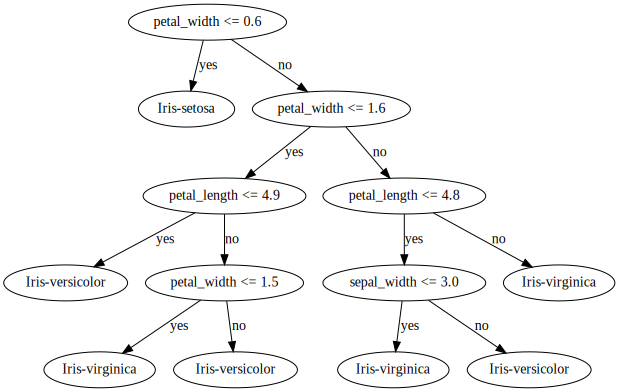

In [39]:
## To get unique name for node.
unique_suffix = iter(np.arange(10000)) 
## intialize the object.
tree_diagram = Digraph()
build_tree(tree)
tree_diagram

In [40]:
# tree_diagram.render('Titanic.gv',view = True)